# Testing the WordCloud library

I've chosen to use this library because there is no need to re-invent the wheel. Most naive implementations using bare matplotlib have superimposed words.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import io
from collections import Counter
from wordcloud import WordCloud
import plotly.graph_objs as go
from PIL import Image
import numpy as np
from utils import read_mongo, json_pandas
from npl_utils import process, init_counter

In [ ]:
# Let's load the db from mongodb
df = read_mongo('dbTweets', 'tweets_chile')

In [ ]:
def get_word_frequency(dataframe, wordlist):
    """
    Count how many tweets contain a given word
    :param dataframe: Pandas dataframe from the tweepy mining
    :param wordlist: array-like with the keywords
    
    TODO: - drop dependency on numpy?
    """
    word_freq = dict()
    for word in wordlist:
        word_freq[word] = np.where(df['text'].str.contains(word))[0].size
    
    return word_freq

In [ ]:
wordlist = io.open('kw.csv').read()
wordlist = wordlist.split(', ')
wf = get_word_frequency(df, wordlist)

Vanilla example of WordCloud functionality

In [ ]:
word_cloud = WordCloud().generate_from_frequencies(wf)
plt.imshow(word_cloud)

Now let's make this bigger and with nicer colors

In [ ]:
word_cloud = WordCloud(background_color='white', colormap='plasma', width= 1200, height=800).generate_from_frequencies(wf)
fig, ax = plt.subplots(figsize=(12,8))
ax.axis('off')
ax.imshow(word_cloud, interpolation='bicubic');
plt.savefig('wordcloud-test.png')

In [ ]:
import plotly.graph_objects as go
from PIL import Image
# Create figure
fig = go.Figure()

# Constants
img_width = 1600
img_height = 900
scale_factor = 0.5

# Add invisible scatter trace.
# This trace is added to help the autoresize logic work.
fig.add_trace(
    go.Scatter(
        x=[0, img_width * scale_factor],
        y=[0, img_height * scale_factor],
        mode="markers",
        marker_opacity=0
    )
)

# Configure axes
fig.update_xaxes(
    visible=False,
    range=[0, img_width * scale_factor]
)

fig.update_yaxes(
    visible=False,
    range=[0, img_height * scale_factor],
    # the scaleanchor attribute ensures that the aspect ratio stays constant
    scaleanchor="x"
)

# Add image
fig.update_layout(
    images=[go.layout.Image(
        x=0,
        sizex=img_width * scale_factor,
        y=img_height * scale_factor,
        sizey=img_height * scale_factor,
        xref="x",
        yref="y",
        opacity=1.0,
        layer="below",
        sizing="stretch",
        source=Image.fromarray(word_cloud.to_array()))]
)


# Configure other layout
fig.update_layout(
    width=img_width * scale_factor,
    height=img_height * scale_factor,
    margin={"l": 0, "r": 0, "t": 0, "b": 0},
)

# Disable the autosize on double click because it adds unwanted margins around the image
# More detail: https://plot.ly/python/configuration-options/
fig.show(config={'doubleClick': 'reset'})


Ok, so what I need is a function that receives a dataframe and returns a PIL Image object with the wordcloud

In [ ]:
from main import get_keywords
kw = get_keywords()
def create_wordcloud_raster(dataframe, wordlist,
                            wc_kwargs=dict(background_color='white', colormap='plasma', width= 1200, height=800)):
    """
    Generate a wordcloud of the keywords given, wheighted by the number of 
    unique tweets they appear in.
    :param dataframe: Pandas DataFrame object. It must contain a 'text' column with the
    tweets from the stream.
    :param wordlist: list of strings to plot in the word cloud.
    :param wc_kwargs: dict of keyword arguments to give to the WordCloud
    constructor.
    """
    wf = get_word_frequency(dataframe, wordlist)
    word_cloud = WordCloud(**wc_kwargs).generate_from_frequencies(wf)
    return Image.fromarray(word_cloud.to_array())

create_wordcloud_raster(df, kw)

In [ ]:
from collections import Counter

def count(string):
    return Counter(string.split())
    
count_map_list = list(map(count, df['tweet'][:10]))
master_count = sum(count_map_list, Counter())

In [ ]:
master_count

In [ ]:
from gensim.utils import simple_preprocess
simple_preprocess(df['tweet'][0], min_len=5,max_len=40, deacc=True)

In [ ]:
import io
import pprint
import gensim.parsing as gp
from gensim.utils import deaccent

with open('stopwords-es.txt', 'r') as file:
    stopwords = list()
    for line in file:
        stop_word = deaccent(line.strip('\n'))
        stopwords.append(stop_word)
stopwords = frozenset(stopwords)

In [ ]:
df = pd.read_csv('OutputStreaming_20191101-171445.csv')

In [ ]:
import re
tw_handles = r"([@][A-z]+)|([#][A-z]+)"
urls = r"((\w+:\/\/)[-a-zA-Z0-9:@;?&=\/%\+\.\*!'\(\),\$_\{\}\^~\[\]`#|]+)"
multi_pattern = '|'.join([tw_handles, urls])
non_plain_re = re.compile(multi_pattern, re.UNICODE)

def remove_non_plain(document):
    return non_plain_re.sub('', document)


def strip_punctuation(token):
    return deaccent(token).strip('",.:;?¿-()[]<>!¡“”|*/\=+&$% ')

doc = df['text'][11]
# filtered_tokenization = [strip_punctuation(word) for word in remove_non_plain(doc).lower().split() if word not in stopwords]
# print(filtered_tokenization)

def process(doc):
    wordbag = list()
    for token in remove_non_plain(doc).lower().split():
        token = strip_punctuation(token)
        if token not in stopwords and token != '' and token != 'rt':
            wordbag.append(token)
    return set(wordbag)

documents = map(process, df['text'])
tfs = Counter()
for document in documents:
    tfs.update(document)

# from gensim.corpora import Dictionary

# dct = Dictionary(documents)
# tfs= dict()
# for token in dct.values():
#     id_ = dct.token2id[token]
#     tfs[token] = dct.cfs[id_]

# tfs = Counter(tfs)

In [ ]:
wc = WordCloud().generate_from_frequencies(tfs)
plt.imshow(wc)

In [ ]:
df = json_pandas(read_mongo('dbTweets', 'tweets_chile',
                           query_fields={"dateTweet":1, "tweet":1, "screenName":1},
                           json_only=True, num_limit=10 ** 5))

twiterator = map(process, df['tweet'])
ctmain = init_counter(twiterator)

In [ ]:
df['dateTweet'][0]

In [ ]:
ctmain.most_common(10)

In [ ]:
df = json_pandas(read_mongo('dbTweets', 'tweets_chile',
                           query_fields={"dateTweet":1, "tweet":1, "screenName":1},
                           json_only=True, num_limit=10 ** 5))
ctmain.update(init_counter(map(process, df['tweet'])))

In [ ]:
def create_wc(counter: object, wc_kwargs: object = {"background_color": 'white', "colormap": 'plasma',
                                                  "width": 1200, "height": 800}) -> object:
    """
    Generate a wordcloud of the keywords given, wheighted by the number of
    unique tweets they appear in. Returns a go.Figure() instance.

    :param tpm: Dataframe with the words frequency per minute.
    :param keywords: list of strings to plot in the word cloud.
    :param wc_kwargs: dict of keyword arguments to give to the WordCloud
    constructor.
    """
    # Build the word cloud from the data
#     wf = get_word_frequency(tpm, keywords)
#     new_keywords = []
#     for key in keywords:
#         if wf[key] > 0:
#             new_keywords.append(key)

#     keywords = new_keywords
#     wf = {key:wf[key] for key in keywords}
#     if len(wf) == 0:
#         return go.Figure()

    word_cloud = WordCloud(**wc_kwargs).generate_from_frequencies(counter)

    wc_raster = Image.fromarray(word_cloud.to_array())

    # Call the constructor of Figure object
    fig = go.Figure()

    # Constants
    img_width = 1600
    img_height = 900
    scale_factor = 0.5

    # Add invisible scatter trace.
    # This trace is added to help the autoresize logic work.
    fig.add_trace(
        go.Scatter(
            x=[0, img_width * scale_factor],
            y=[0, img_height * scale_factor],
            mode="markers",
            marker_opacity=0
        )
    )

    # Configure axes
    fig.update_xaxes(
        visible=False,
        range=[0, img_width * scale_factor]
    )

    fig.update_yaxes(
        visible=False,
        range=[0, img_height * scale_factor],
        # the scaleanchor attribute ensures that the aspect ratio stays constant
        scaleanchor="x"
    )

    # Add image
    fig.update_layout(
        images=[go.layout.Image(
            x=0,
            sizex=img_width * scale_factor,
            y=img_height * scale_factor,
            sizey=img_height * scale_factor,
            xref="x",
            yref="y",
            opacity=1.0,
            layer="below",
            sizing="stretch",
            source=wc_raster)]
    )

    # Configure other layout
    fig.update_layout(
        width=img_width * scale_factor,
        height=img_height * scale_factor,
        margin={"l": 0, "r": 0, "t": 0, "b": 0}
    )
    return fig

create_wc(dict(ctmain.most_common(35)))

In [ ]:
from gensim.parsing.preprocessing import strip_punctuation, strip_punctuation2
strip_punctuation2('23197(&**Ŷ*((*jhj,sdhja<>?/|œh👽')

In [ ]:
from pprint import pprint
pprint(df['tweet'][999])
pprint('----')
pprint(Counter(set(process(df['tweet'][999]))))

In [ ]:
dict(ctmain.most_common(15))

In [ ]:
from es_lemmatizer import lemmatize
import spacy
nlp = spacy.load('es_core_news_sm')
nlp.add_pipe(lemmatize, after="tagger")
doc = nlp('Hola esto es una frase')
print([(w.text, w.pos_) for w in doc])

In [ ]:
texts = ['Esto es un texto', 'Me gustas tú', 'En el barrio La Cachimba se ha formado la corredera']
for doc in nlp.pipe(texts, batch_size=50):
    print(doc.parsed)


In [ ]:
lemmas = lemmatize(doc)
lemmas.to_json()

In [ ]:
from pymongo import MongoClient

client = MongoClient()
db = client.dbTweets

# print collection statistics
# events is the collection name here

# print database statistics
print(db.command("dbstats")['storageSize']*1e-9)

In [ ]:
import classifier
clf = classifier.SentimentClassifier()

In [ ]:
index = np.random.randint(1, high=1000)
tweet = df['text'][index]
print('Tuit número {}: {} ==> {}'.format(index, tweet, clf.predict(tweet)))

In [6]:
df = json_pandas(read_mongo('TweetScraper', 'tweet',
                           query_fields={"datetime":1, "text":1, "usernameTweet":1, 'user_id':1},
                           json_only=True))
# df = json_pandas(read_mongo('TweetScraper', 'user',
#                            query_fields={"user_id":1, "statuses_count":1, "name":1, 'followers_count':1},
#                            json_only=True))

In [8]:
df.datetime

0       2019-11-13 17:57:45
1       2019-11-13 17:57:44
2       2019-11-13 17:57:44
3       2019-11-13 17:57:43
4       2019-11-13 17:57:43
                ...        
72295   2019-11-12 23:27:30
72296   2019-11-12 23:27:29
72297   2019-11-12 23:27:29
72298   2019-11-12 23:27:29
72299   2019-11-12 23:27:29
Name: datetime, Length: 72300, dtype: datetime64[ns]

In [6]:
twiterator = map(process, df['text'])
ctmain = init_counter(twiterator)


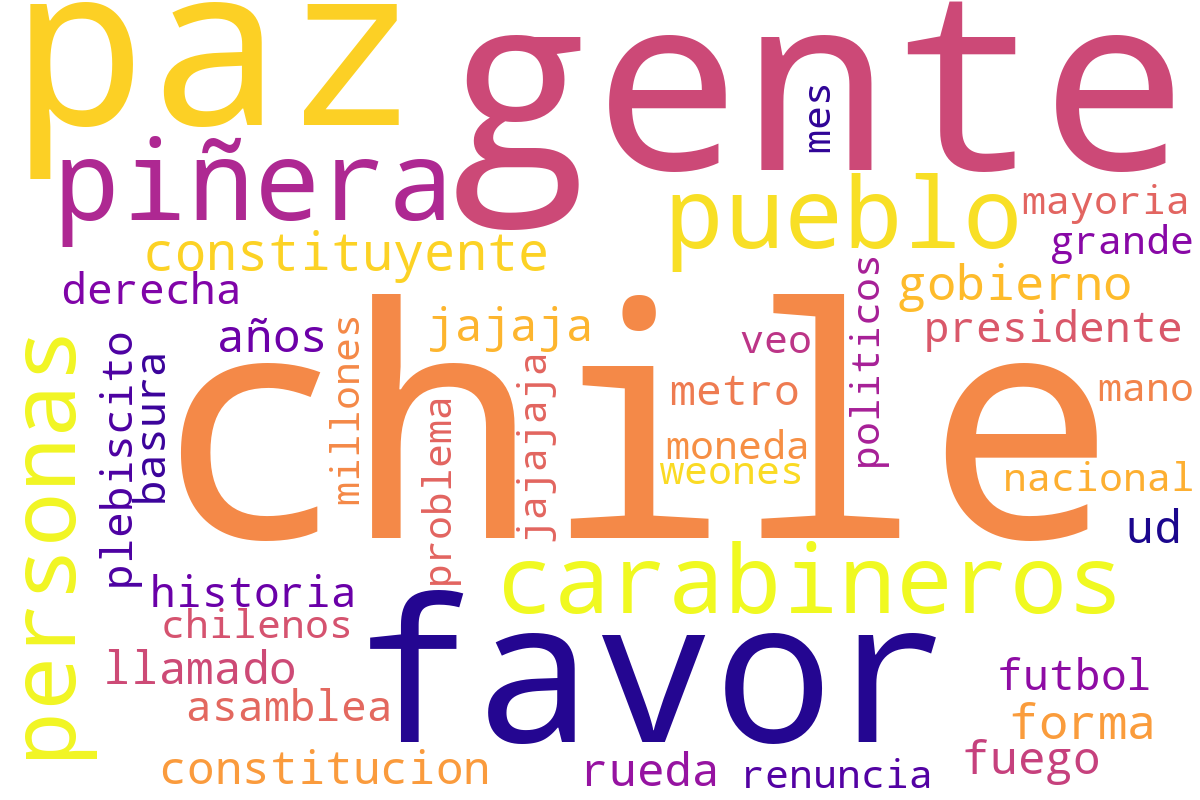

In [7]:
from utils_app import create_wc2
create_wc2(ctmain, n=40)

In [10]:
print(df['text'][199])

Realizarán operativo gratuito para mascotas en Colchane.  http://iquiquevision.cl/2019/11/13/realizaran-operativo-gratuito-para-mascotas-en-colchane/ 


In [3]:
df['user_id']

0                  368983314
1        1146836967440752640
2                 3524199436
3                  138080432
4                   19076206
                ...         
72295     708749721494536192
72296     798976901037621248
72297    1062294927172947968
72298              108405324
72299              110687835
Name: user_id, Length: 72300, dtype: int64